In [257]:
%%writefile /tmp/LP_detect.py
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from LogGabor import LogGabor

parser = argparse.ArgumentParser(description='PyTorch MNIST detector')
parser.add_argument('--batch_size', type=int, default=100, metavar='N',
                   help='input batch size for training (default: 100)')
parser.add_argument('--eval_batch_size', type=int, default=1000, metavar='N',
                   help='input batch size for evaluation (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                   help='number of training epochs (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                   help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                   help='SGM momentum for training (default: 0.5)')
parser.add_argument('--not_cuda', action='store_true', default=False,
                   help='Disables use of GPU during training (default: False)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                   help='random number seed (default: 1)')
args = parser.parse_args()
args.cuda = not args.not_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=args.eval_batch_size, shuffle=True, **kwargs)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # First layer        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # Second layer
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(480, 50) # Input size, output size
        self.fc2 = nn.Linear(50, 2)   # Input size, output size
        
    def forward(self, x):
        # F.relu : Applies rectified linear unit function element-wise
        # F.max_pool2d : Applies 2d max pooling over an input signal    
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 480)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
model = Net()
if args.cuda: model.cuda()
    
optimizer = optim.SGD(model.parameters(), 
                      lr=args.lr, 
                      momentum=args.momentum)

def mnist_reshape_128(x, i_offset=0, j_offset=0, N_pix=24):
    assert x.shape[2:4] == (28,28)
    #x_translate = np.multiply(x.min(), np.ones((x.shape[0], 1, N_pix*(128/N_pix), N_pix*(128/N_pix))))
    x_translate = x.min() * np.ones((x.shape[0], 1, N_pix*(128/N_pix), N_pix*(128/N_pix)))
    image = x_translate[:, :, (N_pix+22+i_offset):(2*N_pix+22+i_offset), (N_pix+22+j_offset):(2*N_pix+22+j_offset)]
    return image

def vectorization(N_theta,
                  N_orient,
                  N_scale,
                  N_phase,
                  N_X,
                  N_Y):
    phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))

    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
    phase = np.pi/4
    edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))
    
    for i_theta in range(N_theta):
        for i_orient in range(N_orient):
            for i_scale in range(N_scale):
                ecc =  .5**(N_scale - i_scale)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
                for i_phase in range(N_phase):
                    params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                    phase = i_phase * np.pi/2
                    phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            
    return phi

def train(epoch):
    model.train()
    N_theta, N_orient, N_scale, N_phase, N_X, N_Y = 6, 8, 5, 2, 128, 128
    phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)
    phi_vector = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda: data, target = data.cuda(), target.cuda()
        #data, target = Variable(data), Variable(target)
        i_off, j_off = int(np.random.randn()*15), int(np.random.randn()*15)
        coord = (i_off, j_off)
        data_transform1 = mnist_reshape_128(data, i_off, j_off)
        print('dbg1', data_transform1.shape)
        #data_transform2 = phi_vector @ np.ravel(data_transform1)
        data_transform2 = np.dot(phi_vector, np.ravel(data_transform1))
        optimizer.zero_grad()
        output = model(data_transform2)
        loss = F.nll_loss(output, coord)
        loss.backward()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
                                                                       batch_idx * len(data), 
                                                                       len(train_loader.dataset),
                                                                       100. * batch_idx / len(train_loader), 
                                                                       loss.data[0]))
        
def test(test_loader=test_loader):
    model.eval()
    N_theta, N_orient, N_scale, N_phase, N_X, N_Y = 6, 8, 5, 2, 128, 128
    phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)
    phi_vector = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
    test_loss, correct = 0, 0
    for data, target in test_loader:
        if args.cuda: data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        i_off, j_off = int(np.random.randn()*15), int(np.random.randn()*15)
        coord = (i_off, j_off)
        data_transform1 = mnist_reshape_128(data, i_off, j_off)
        data_transform2 = phi_vector @ np.ravel(data_transform1)
        output = model(data_transform2)
        test_loss += F.nll_loss(output, coord, size_average=False).data[0]
        pred = output.data[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, 
                                                                                 correct, 
                                                                                 len(test_loader.dataset),
                                                                                 100. * correct / len(test_loader.dataset)))

Overwriting /tmp/LP_detect.py


In [258]:
%run /tmp/LP_detect.py

In [259]:
import os
import time

path = "MNIST_detector.pt"
if os.path.isfile(path):
    print('Loading file')
    model.load_state_dict(torch.load(path))
else:
    print('Training model')
    t0 = time.time()
    for epoch in range(1, args.epochs+1):
        print(epoch)
        train(epoch)
    torch.save(model.state_dict(), path)
    print('Done in', time.time()-0, 'seconds')

Training model
1
dbg4 torch.Size([100, 1, 28, 28])
dbg3 (100, 1, 128, 128)
dbg2 (100, 1, 24, 24)
dbg1 (100, 1, 24, 24)


ValueError: shapes (480,16384) and (57600,) not aligned: 16384 (dim 1) != 57600 (dim 0)

torch.Size([100, 1, 28, 28])
(100, 1, 128, 128)


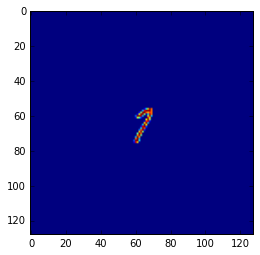

In [256]:
%matplotlib inline
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

i_shift, j_shift = 0, 0
N_pix = 28

for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)
    break
    
x = data
x_translate = x.min() * np.ones((x.shape[0], 1, N_pix*(128/N_pix), N_pix*(128/N_pix)))
print(x_translate.shape)
x_translate[:, :, (N_pix+22+i_shift):(2*N_pix+22+i_shift), (N_pix+22+j_shift):(2*N_pix+22+j_shift)] = x

fig, ax = plt.subplots()
ax.imshow(x_translate[0, 0, :, :])